In [ ]:
!pip install deepmol
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from deepmol.loaders.loaders import CSVLoader

# load a dataset from a CSV (required fields: dataset_path and smiles_field)
loader = CSVLoader( dataset_path= 'Beta-secretase1_bioactivity_withdescriptors.csv',
                   smiles_field='canonical_smiles',
                   id_field='molecule_chembl_id',
                   labels_fields=['class'],
                   features_fields=['MW', 'LogP', 'NumHDonors', 'NumHAcceptors' , 'NumHeavyAtoms' , 'num_chiral_centers_list' , 'polarizabilities' , 'num_rings' , 'rotatable_bonds'], #'pIC50'
                   shard_size=8321,
                   mode='auto')

dataset = loader.create_dataset()

# print shape of the dataset (molecules, X, y)
dataset.get_shape()

2023-03-29 01:31:43,378 — INFO — Assuming classification since there are less than 10 unique y values. If otherwise, explicitly set the mode to 'regression'!


INFO:deepmol.log:Assuming classification since there are less than 10 unique y values. If otherwise, explicitly set the mode to 'regression'!


2023-03-29 01:31:43,383 — INFO — Mols_shape: (8321,)


INFO:deepmol.log:Mols_shape: (8321,)


2023-03-29 01:31:43,387 — INFO — Features_shape: (8321, 9)


INFO:deepmol.log:Features_shape: (8321, 9)


2023-03-29 01:31:43,391 — INFO — Labels_shape: (8321,)


INFO:deepmol.log:Labels_shape: (8321,)


((8321,), (8321, 9), (8321,))

In [ ]:
#  Custom Standardizer

heavy_standardisation = {
    'REMOVE_ISOTOPE': True,
    'NEUTRALISE_CHARGE': True,
    'REMOVE_STEREO': True,
    'KEEP_BIGGEST': True,
    'ADD_HYDROGEN': True,
    'KEKULIZE': False,
    'NEUTRALISE_CHARGE_LATE': True}

 #   from deepmol.unsupervised import UMAP

#  ump = UMAP()
#  umap_df = ump.run_unsupervised(dataset)
#  ump.plot(umap_df.X, path='umap_output.png')
from deepmol.splitters.splitters import SingletaskStratifiedSplitter

# Data Split
splitter = SingletaskStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.9,
                                                                             frac_valid=0.15, frac_test=0.15)
train_dataset.get_shape()

2023-03-29 01:31:43,835 — INFO — Mols_shape: (5824,)


INFO:deepmol.log:Mols_shape: (5824,)


2023-03-29 01:31:43,840 — INFO — Features_shape: (5824, 9)


INFO:deepmol.log:Features_shape: (5824, 9)


2023-03-29 01:31:43,845 — INFO — Labels_shape: (5824,)


INFO:deepmol.log:Labels_shape: (5824,)


((5824,), (5824, 9), (5824,))

In [ ]:
valid_dataset.get_shape()

2023-03-29 01:23:32,400 — INFO — Mols_shape: (1248,)


INFO:deepmol.log:Mols_shape: (1248,)


2023-03-29 01:23:32,404 — INFO — Features_shape: (1248, 9)


INFO:deepmol.log:Features_shape: (1248, 9)


2023-03-29 01:23:32,407 — INFO — Labels_shape: (1248,)


INFO:deepmol.log:Labels_shape: (1248,)


((1248,), (1248, 9), (1248,))

In [ ]:
test_dataset.get_shape()

2023-03-29 01:23:32,420 — INFO — Mols_shape: (1249,)


INFO:deepmol.log:Mols_shape: (1249,)


2023-03-29 01:23:32,424 — INFO — Features_shape: (1249, 9)


INFO:deepmol.log:Features_shape: (1249, 9)


2023-03-29 01:23:32,427 — INFO — Labels_shape: (1249,)


INFO:deepmol.log:Labels_shape: (1249,)


((1249,), (1249, 9), (1249,))

In [ ]:
train_dataset

In [ ]:
# Model building using Keras model example

from keras.models import Sequential
from keras.layers import Dense, Dropout
from deepmol.metrics.metrics import Metric
from sklearn import tree, model_selection, metrics
from deepmol.metrics.metrics_functions import roc_auc_score 
from deepmol.metrics.metrics_functions import precision_score
from deepmol.metrics.metrics_functions import accuracy_score
from deepmol.metrics.metrics_functions import confusion_matrix
from deepmol.metrics.metrics_functions import classification_report


input_dim = train_dataset.X.shape[1]


def create_model(optimizer='adam', dropout=0.5, input_dim=input_dim):
  # create model
  model = Sequential()
  model.add(Dense(12, input_dim=input_dim, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model


from deepmol.models.keras_models import KerasModel

model = KerasModel(create_model, epochs=5, verbose=1, optimizer='adam')

# train model
model.fit(train_dataset)

Epoch 1/5
583/583 [==============================] - 2s 2ms/step - loss: 10.5193 - accuracy: 0.5769
Epoch 2/5
583/583 [==============================] - 1s 2ms/step - loss: 0.6285 - accuracy: 0.7648
Epoch 3/5
583/583 [==============================] - 1s 2ms/step - loss: 0.4743 - accuracy: 0.8314
Epoch 4/5
583/583 [==============================] - 1s 2ms/step - loss: 0.4620 - accuracy: 0.8372
Epoch 5/5
583/583 [==============================] - 1s 2ms/step - loss: 0.4596 - accuracy: 0.8353


In [ ]:
# make prediction on the test dataset with the model
model.predict(test_dataset)

# evaluate model using multiple metrics

metrics = [Metric(roc_auc_score),
           Metric(precision_score),
           Metric(accuracy_score),
           Metric(confusion_matrix),
           Metric(classification_report)]

print('Training set score:', model.evaluate(train_dataset, metrics))
print('Test set score:', model.evaluate(test_dataset, metrics))

#   Calculating Accuracy

182/182 [==============================] - 0s 2ms/step
Training set score: ({'roc_auc_score': 0.5995386711270559, 'precision_score': 0.8413309982486865, 'accuracy_score': 0.8428914835164835, 'confusion_matrix': array([[ 105,  906],
       [   9, 4804]]), 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.92      0.10      0.19      1011\n           1       0.84      1.00      0.91      4813\n\n    accuracy                           0.84      5824\n   macro avg       0.88      0.55      0.55      5824\nweighted avg       0.86      0.84      0.79      5824\n'}, {})
40/40 [==============================] - 0s 2ms/step
Test set score: ({'roc_auc_score': 0.6327444336882866, 'precision_score': 0.8390243902439024, 'accuracy_score': 0.8406725380304243, 'confusion_matrix': array([[  18,  198],
       [   1, 1032]]), 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.95      0.08      0.15  

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
X_train,y_train=train_dataset.X, train_dataset.y
X_test,y_test=test_dataset.X,test_dataset.y

In [ ]:
X_train[0]

array([591.705 ,   3.3105,   6.    ,   6.    ,  38.    ,   3.    ,
       162.934 ,   3.    ,  20.    ])

In [ ]:
xg=XGBClassifier()
xg.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
y_preds=xg.predict(X_test)

In [ ]:
y_preds

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
accuracy_score(y_test,y_preds)

0.8863090472377902

In [ ]:
xg.score(X_test,y_test)

0.8863090472377902

### Regression pIC50

In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
dfr=pd.read_csv('Beta-secretase1_bioactivity_withdescriptors.csv')
dfr.drop(columns=["canonical_smiles","molecule_chembl_id",'class'], inplace=True)

In [ ]:
dfr

,MW,LogP,NumHDonors,NumHAcceptors,pIC50,NumHeavyAtoms,num_chiral_centers_list,polarizabilities,num_rings,rotatable_bonds
0,999.085,-1.43550,13.0,13.0,6.384050,38,9,251.3843,2,38.0
1,893.005,-1.73610,12.0,12.0,8.698970,38,9,224.6472,1,37.0
2,751.988,2.35350,8.0,9.0,6.337242,38,5,201.2564,1,34.0
3,767.987,1.36900,8.0,9.0,4.468521,38,5,201.8078,1,34.0
4,717.722,4.31960,7.0,7.0,7.698970,38,3,185.2133,4,19.0
...,...,...,...,...,...,...,...,...,...,...
8316,675.849,2.50892,8.0,9.0,4.886057,38,6,180.2051,2,27.0
8317,671.905,3.38110,7.0,8.0,4.853872,38,6,185.1508,3,25.0
8318,651.915,3.09270,7.0,8.0,5.000000,38,6,177.6868,2,25.0
8319,412.537,4.23600,1.0,5.0,9.221849,38,1,124.0364,5,4.0


In [ ]:
X=dfr.drop(columns='pIC50').values
y=dfr['pIC50'].values

In [ ]:
X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.2)

In [ ]:
model=XGBRegressor().fit(X_train,y_train)
y_pred=model.predict(X_test)
model.score(X_test,y_test)

0.5574709722738835

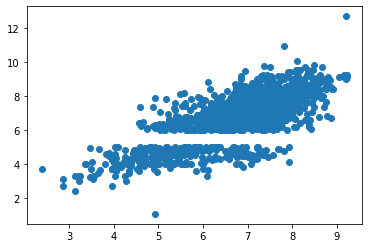

In [ ]:
plt.scatter(y_pred,y_test)

## Inference

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, AllChem

In [ ]:
smiles_example="CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O)O)C(C)C)C(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)O"

In [ ]:
def clean_smiles(i):
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  return cpd_longest
clean_smiles(smiles_example)

'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O)O)C(C)C)C(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)O'

In [ ]:
# descriptors

def lipinski(smiles):
    moldata= Chem.MolFromSmiles(smiles) 
    
    desc_MolWt = Descriptors.MolWt(moldata)
    desc_MolLogP = Descriptors.MolLogP(moldata)
    desc_NumHDonors = Lipinski.NumHDonors(moldata)
    desc_NumHAcceptors = Lipinski.NumHAcceptors(moldata)
        
    descriptors = {'MW':desc_MolWt,'LogP':desc_MolLogP,'NumHDonors':desc_NumHDonors, 'NumHAcceptors':desc_NumHAcceptors}
    
    return descriptors
lipinski(smiles_example)

{'MW': 999.0849999999999,
 'LogP': -1.4355000000000018,
 'NumHDonors': 13,
 'NumHAcceptors': 13}

In [ ]:
def calculate_rotatable_bonds(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # add hydrogens
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # generate 3D coordinates
    AllChem.UFFOptimizeMolecule(mol)  # optimize 3D structure
    num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)
    return num_rotatable_bonds

In [ ]:
def get_rotatable_bonds(smiles):
  mol = Chem.MolFromSmiles(smiles)
  if mol is None:
      num_rotatable_bonds = None
  else:
      mol = Chem.AddHs(mol)  # add hydrogens
      try:
          AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # generate 3D coordinates
          AllChem.UFFOptimizeMolecule(mol)  # optimize 3D structure
          num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)
      except ValueError:
          num_rotatable_bonds = None
  return {'rotatable_bonds':num_rotatable_bonds}
get_rotatable_bonds(smiles_example)

{'rotatable_bonds': 38}

In [ ]:
def calculate_num_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    num_rings = Descriptors.RingCount(mol)
    return {'num_rings':num_rings}
calculate_num_rings(smiles_example)

{'num_rings': 2}

In [ ]:
def calculate_polarizability(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return {"polarizabilities":Descriptors.MolMR(mol)}
calculate_polarizability(smiles_example)

{'polarizabilities': 251.38429999999948}

In [ ]:
def calculate_num_chiral_centers(smiles):
    mol = Chem.MolFromSmiles(smiles)
    chiral_centers = Chem.FindMolChiralCenters(mol)
    num_chiral_centers = len(chiral_centers)
    return {"num_chiral_centers_list":num_chiral_centers}
calculate_num_chiral_centers(smiles_example)

{'num_chiral_centers_list': 9}

In [ ]:
def calculate_num_heavy_atoms(smile):
    mol = Chem.MolFromSmiles(smile)
    num_heavy_atoms = mol.GetNumHeavyAtoms()
    return {"NumHeavyAtoms":num_heavy_atoms}
calculate_num_heavy_atoms(smiles_example)

{'NumHeavyAtoms': 71}

In [ ]:
def input_pipeline(smiles):
  smiles=clean_smiles(smiles)
  features={'canonical_smiles':smiles}
  features|=calculate_num_heavy_atoms(smiles)
  features|=calculate_num_chiral_centers(smiles)
  features|=calculate_num_rings(smiles)
  features|=get_rotatable_bonds(smiles)
  features|=lipinski(smiles)
  return features
s=input_pipeline(smiles_example)
s

{'canonical_smiles': 'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O)O)C(C)C)C(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)O',
 'NumHeavyAtoms': 71,
 'num_chiral_centers_list': 9,
 'num_rings': 2,
 'rotatable_bonds': 38,
 'MW': 999.0849999999999,
 'LogP': -1.4355000000000018,
 'NumHDonors': 13,
 'NumHAcceptors': 13}

In [ ]:
xg.predict([list(s.values())[1:]])[0]

0

In [ ]:
def infer_smiles(smiles):
  features=input_pipeline(smiles)
  predicted_class=xg.predict([list(s.values())[1:]])[0]
  result=features|{'class':predicted_class}
  return result

In [ ]:
infer_smiles( 'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O)O)C(C)C)C(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)O')

{'canonical_smiles': 'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O)O)C(C)C)C(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)O',
 'NumHeavyAtoms': 71,
 'num_chiral_centers_list': 9,
 'num_rings': 2,
 'rotatable_bonds': 38,
 'MW': 999.0849999999999,
 'LogP': -1.4355000000000018,
 'NumHDonors': 13,
 'NumHAcceptors': 13,
 'class': 0}